# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [56]:
# Add your imports here
import seaborn as sns
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from joblib import dump, load

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

### First look at data

In [3]:
"""
Dataframe Reperesentation
"""
data

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,...,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,...,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,...,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,...,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,...,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,NaN,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,5.0,...,NaN,55.0,NaN,107.0,NaN,79.0,56.0,3.0,False,True
44732,Skrelp,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,6.0,...,NaN,65.0,59.0,70.0,79.0,79.0,33.0,1.0,False,False
38158,Florges,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,6.0,...,NaN,104.0,91.0,61.0,97.0,117.0,68.0,3.0,NaN,True
860,Pachirisu,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,4.0,...,Dragon,50.0,70.0,101.0,112.0,97.0,83.0,4.0,NaN,True


In [4]:
"""
Dataframe info first observations:

    - Type 2 feature contains alot of nulls (Check what to do)
    - Generation is irrelevant info
    - Legendary is irrelevant info as it is inplicit on the stats
    - Name is irrelevant info
"""
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

In [5]:
"""
Impossible data found in minimums:
    There are some stats in neggative. Look for impossible values.
"""
data.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other
count,35994.000000,36103.000000,35966.000000,36080.000000,36018.000000,36028.000000,36007.000000,35895.000000,36005.000000,35984.000000,35904.000000,35995.000000,35956.000000,36014.000000
mean,69.771879,79.254023,74.663933,73.425139,72.465434,68.790441,3.333630,69.838418,79.254909,74.787961,73.168951,72.582525,68.781622,3.337702
std,26.610838,33.408366,32.402967,33.507089,28.982072,30.178166,1.656558,26.604671,33.160915,32.456015,33.486762,28.986777,29.998563,1.654265
min,1.000000,-4.000000,-7.000000,2.000000,8.000000,-4.000000,1.000000,1.000000,-4.000000,-7.000000,-1.000000,8.000000,-2.000000,1.000000
25%,50.000000,55.000000,51.000000,48.000000,51.000000,46.000000,2.000000,50.000000,55.000000,52.000000,48.000000,51.000000,46.000000,2.000000
50%,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000
75%,81.000000,99.000000,92.000000,95.000000,90.000000,91.000000,5.000000,82.000000,99.000000,92.000000,94.000000,90.000000,91.000000,5.000000
max,255.000000,200.000000,239.000000,203.000000,238.000000,189.000000,6.000000,255.000000,202.000000,241.000000,206.000000,239.000000,188.000000,6.000000


1. Which features are categorical? Which are continuous?

In [6]:
data.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other
count,35994.000000,36103.000000,35966.000000,36080.000000,36018.000000,36028.000000,36007.000000,35895.000000,36005.000000,35984.000000,35904.000000,35995.000000,35956.000000,36014.000000
mean,69.771879,79.254023,74.663933,73.425139,72.465434,68.790441,3.333630,69.838418,79.254909,74.787961,73.168951,72.582525,68.781622,3.337702
std,26.610838,33.408366,32.402967,33.507089,28.982072,30.178166,1.656558,26.604671,33.160915,32.456015,33.486762,28.986777,29.998563,1.654265
min,1.000000,-4.000000,-7.000000,2.000000,8.000000,-4.000000,1.000000,1.000000,-4.000000,-7.000000,-1.000000,8.000000,-2.000000,1.000000
25%,50.000000,55.000000,51.000000,48.000000,51.000000,46.000000,2.000000,50.000000,55.000000,52.000000,48.000000,51.000000,46.000000,2.000000
50%,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000
75%,81.000000,99.000000,92.000000,95.000000,90.000000,91.000000,5.000000,82.000000,99.000000,92.000000,94.000000,90.000000,91.000000,5.000000
max,255.000000,200.000000,239.000000,203.000000,238.000000,189.000000,6.000000,255.000000,202.000000,241.000000,206.000000,239.000000,188.000000,6.000000


**Categorical**:
    
    - Name 
    - Type 1
    - Type 2
    - Legendary
    - Name_other
    - Type 1_other 
    - Type 2_other 
    - Legendary_other
    - Generation
    - Generation_other


**Continous**:

    - HP
    - Attack
    - Defense
    - Sp. Atk
    - Sp. Def
    - Speed
    - HP_other
    - Attack_other
    - Defense_other
    - Sp. Atk_other
    - Sp. Def_other
    - Speed_other
    
    
    

2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

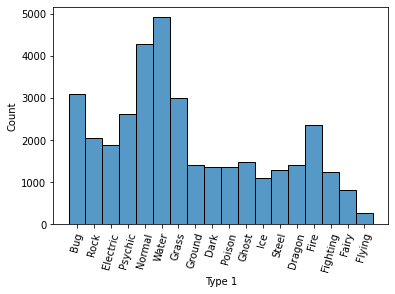

In [7]:
plot = sns.histplot(data = data, x = "Type 1")
plot.tick_params(axis='x', rotation=75)

3. Determine which of the features have missing values. How many missing values there are for each one?

Here we can see that almos all features have missing values. 
As total of entries is 40000 and all features have <40000

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

4. Analize the distribution of the target column. Is it balanced?

In [9]:
"""
Yes it is!
"""
data["Wins"].value_counts()

False    21152
True     18848
Name: Wins, dtype: int64

### More visualitzation on the data

#### Correlations

<AxesSubplot:>

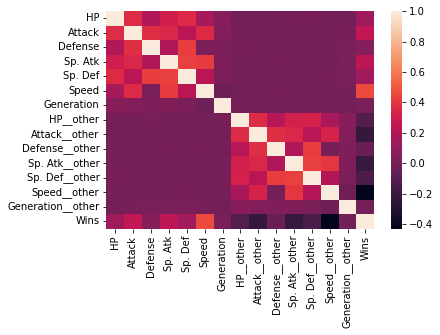

In [10]:
sns.heatmap(data=data.corr())

Seems that there isn't any important correlation here that goes a lot beyoung others.

#### Type relation with statistics

Here we want to check if the Type have some influence in determined statistics in orther to do use it as an heuristic when filling null values:

In [11]:
def get_type_list(data):
    type_1 = list(filter(lambda v: v==v, data["Type 1"].unique()))
    type_2 = list(filter(lambda v: v==v, data["Type 2"].unique()))
    type_1_other = list(filter(lambda v: v==v, data["Type 1__other"].unique()))
    type_2_other = list(filter(lambda v: v==v, data["Type 2__other"].unique()))
    return list(set(type_1 + type_2 + type_1_other + type_2_other))   

In [12]:
type_list =  get_type_list(data)   

In [13]:
def get_all_pokemons(data, cols_to_merge1, cols_to_merge2):
    pokemon = data[cols_to_merge1]
    pokemon_other = data[cols_to_merge2]
    pokemon_other = pokemon_other.rename(columns={'Name__other' : 'Name', 
                                          'Type 1__other' : 'Type 1', 
                                          'Type 2__other' : 'Type 2', 
                                          'HP__other' : 'HP',
                                          'Attack__other' : 'Attack',
                                          'Defense__other' : 'Defense',
                                          'Sp. Atk__other' : 'Sp. Atk',
                                          'Sp. Def__other' : 'Sp. Def',
                                          'Speed__other' : 'Speed',
                                          'Generation__other' : 'Generation',
                                          'Legendary__other' : 'Legendary'
                                         })
    pokemons = pandas.concat([pokemon, pokemon_other])
    return pokemons
cols_to_merge1 = ['Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']
cols_to_merge2 = ['Name__other', 'Type 1__other', 'Type 2__other', 'HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other', 'Generation__other', 'Legendary__other']
pokemons = get_all_pokemons(data, cols_to_merge1, cols_to_merge2)

In [14]:
def split_by_type(dataset):
    type_classification = {}
    for ptype in get_type_list(data):
        type_classification[ptype] = dataset.loc[(dataset['Type 1'] == ptype) | (dataset['Type 2'] == ptype)]
    return type_classification

In [15]:
pokemons_by_type = split_by_type(pokemons)

I decided to use the median becouse there can be some outliers or bad data that make go the mean dont work as good as I expect. Also, the pokemon dataset can have some pokemons with really bad statistics and then a lot mor of decent statistics, but as we have some pokemons with so bad statistics the mean infeer that the type has bad statistics overall.

In [16]:
def structures_median_by_type(pokemons_by_type):
    stats_median_by_type = {
        'HP' : [],
        'Attack' : [],
        'Defense' : [],
        'Sp. Atk' : [],
        'Sp. Def' : [],
        'Speed' : []
    }
    dic_median_by_type = {
        'HP' : {},
        'Attack' : {},
        'Defense' : {},
        'Sp. Atk' : {},
        'Sp. Def' : {},
        'Speed' : {}
    }
    for ptype, dataframe in pokemons_by_type.items():
        stats_median_by_type['HP'].append([ptype, dataframe['HP'].median()])
        dic_median_by_type['HP'][ptype] = dataframe['HP'].median()
        stats_median_by_type['Attack'].append([ptype, dataframe['Attack'].median()])
        dic_median_by_type['Attack'][ptype] = dataframe['Attack'].median()
        stats_median_by_type['Defense'].append([ptype, dataframe['Defense'].median()])
        dic_median_by_type['Defense'][ptype] = dataframe['Defense'].median()
        stats_median_by_type['Sp. Atk'].append([ptype, dataframe['Sp. Atk'].median()])
        dic_median_by_type['Sp. Atk'][ptype] = dataframe['Sp. Atk'].median()
        stats_median_by_type['Sp. Def'].append([ptype, dataframe['Sp. Def'].median()])
        dic_median_by_type['Sp. Def'][ptype] = dataframe['Sp. Def'].median()
        stats_median_by_type['Speed'].append([ptype, dataframe['Speed'].median()])
        dic_median_by_type['Speed'][ptype] = dataframe['Speed'].median()
    return dic_median_by_type, stats_median_by_type
dic_median_by_type, stats_median_by_type = structures_median_by_type(pokemons_by_type)

In [17]:
statistics = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

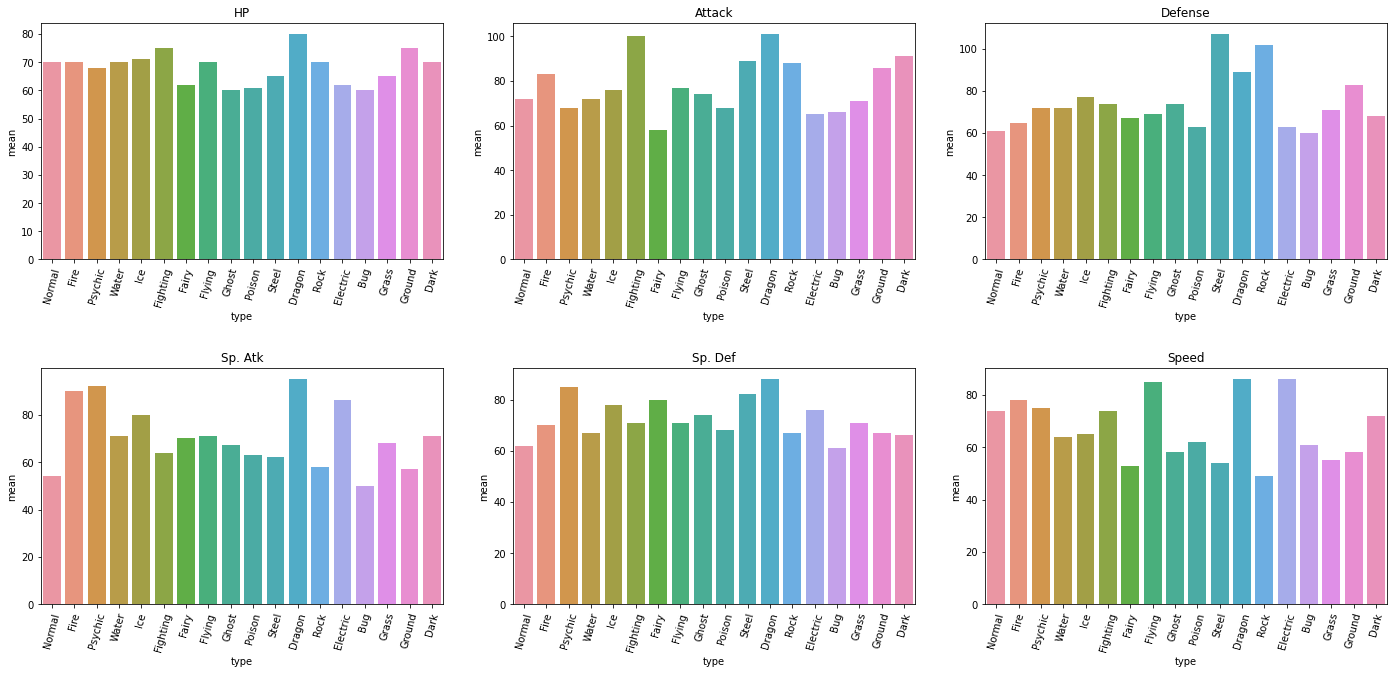

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
persist_mean_by_type = {}
for i,stat in enumerate(statistics):
    mean_by_type = pandas.DataFrame(stats_median_by_type[stat], columns=["type", "mean"])
    sns.barplot(data = mean_by_type, x = "type", y = "mean", ax=ax[math.floor(i/3)][i%3])
    ax[math.floor(i/3)][i%3].set_title(stat)
    ax[math.floor(i/3)][i%3].tick_params(axis='x', rotation=75)
    persist_mean_by_type[stat] = mean_by_type
fig.tight_layout(pad=3.0)

Here we can see that the type comes also implicit in the statistics. Whaty means that a pokemon that is of a certain type will have a preference predetermined by de type in the statistics. So a possibility is to get rid of types so that wee don't have to do a one hot encoder and end with a lot of features, leading the model to overfeat

#### Check nulls

Rows with all nulls

In [19]:
def nans(df): return df[df.isnull().all(axis=1)]
len(nans(data))

0

Rows with at least 1 null

In [20]:
def nans(df): return df[df.isnull().any(axis=1)]
len(nans(data))

38939

In [21]:
def null_count(dataframe):
    count = []
    nulls = 1
    i = 0
    while nulls != 0:
        nulls = len([x for x in dataframe.isnull().sum(axis=1).tolist() if x > i])
        count.append([i, nulls])
        i += 1
    return count

In [22]:
null_count(data)

[[0, 38939],
 [1, 34037],
 [2, 24582],
 [3, 14004],
 [4, 6339],
 [5, 2265],
 [6, 700],
 [7, 174],
 [8, 34],
 [9, 8],
 [10, 1],
 [11, 1],
 [12, 0]]

Damn, a lot of noise :(

#### Check outliers for statistics

As has been observed that each type has peculiarities in its statistics we should look for outliers for each type.

In [23]:
def plot_statistics_boxplots_by_type(ptype):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
    for i,stat in enumerate(statistics):
        sns.boxplot(data=pokemons_by_type[ptype], x=stat, ax=ax[math.floor(i/3)][i%3])
        ax[math.floor(i/3)][i%3].set_title(stat)
        ax[math.floor(i/3)][i%3].tick_params(axis='x', rotation=75)
    fig.tight_layout(pad=3.0)
    return fig

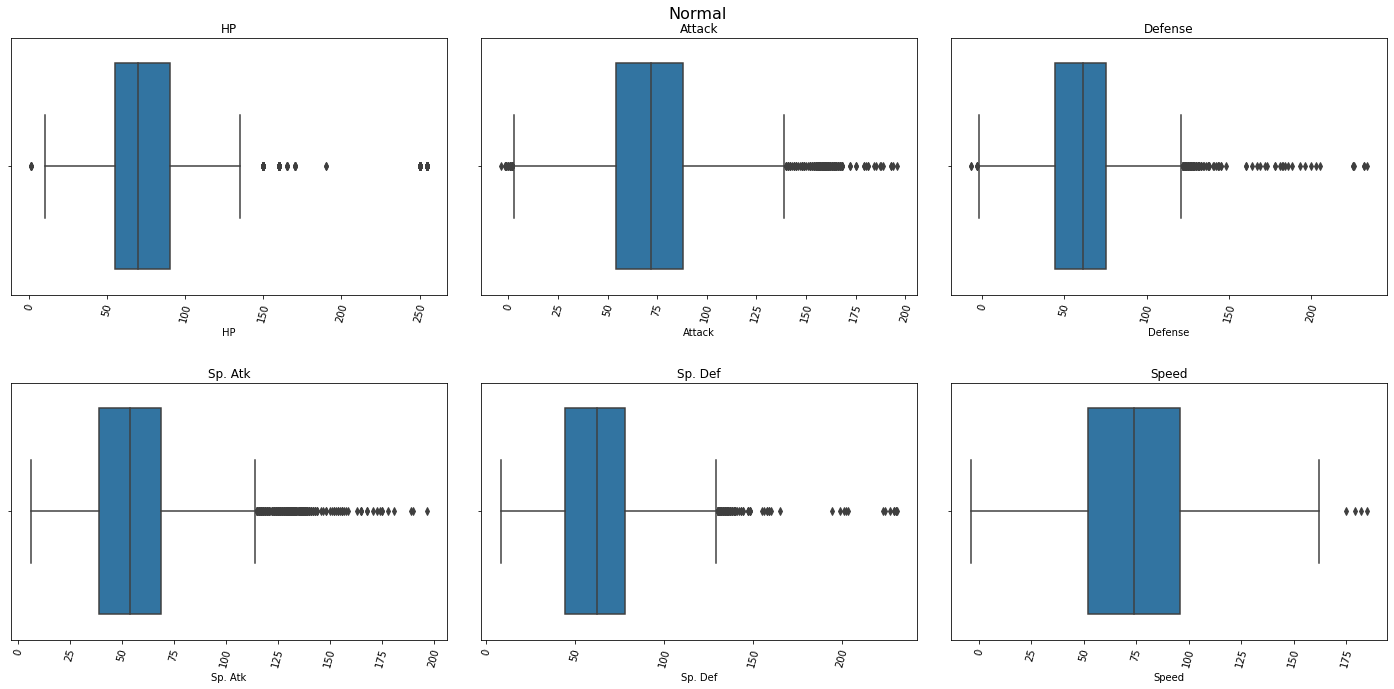

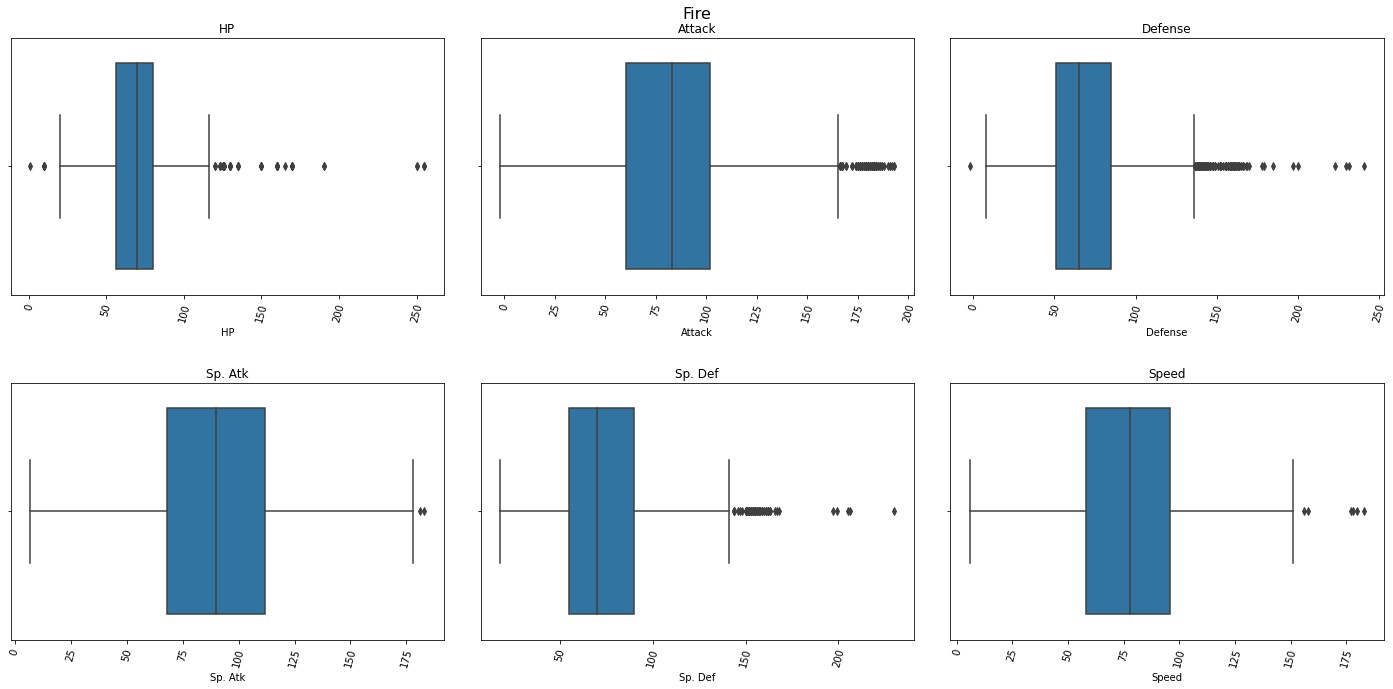

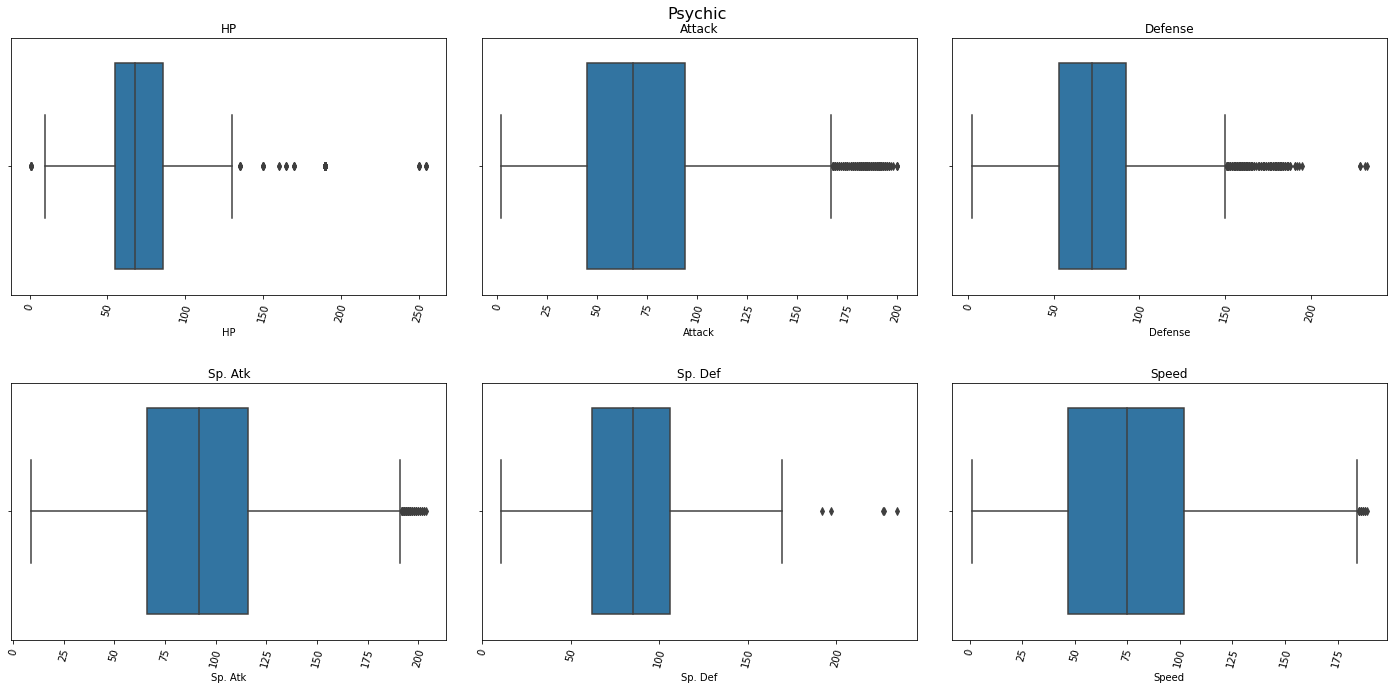

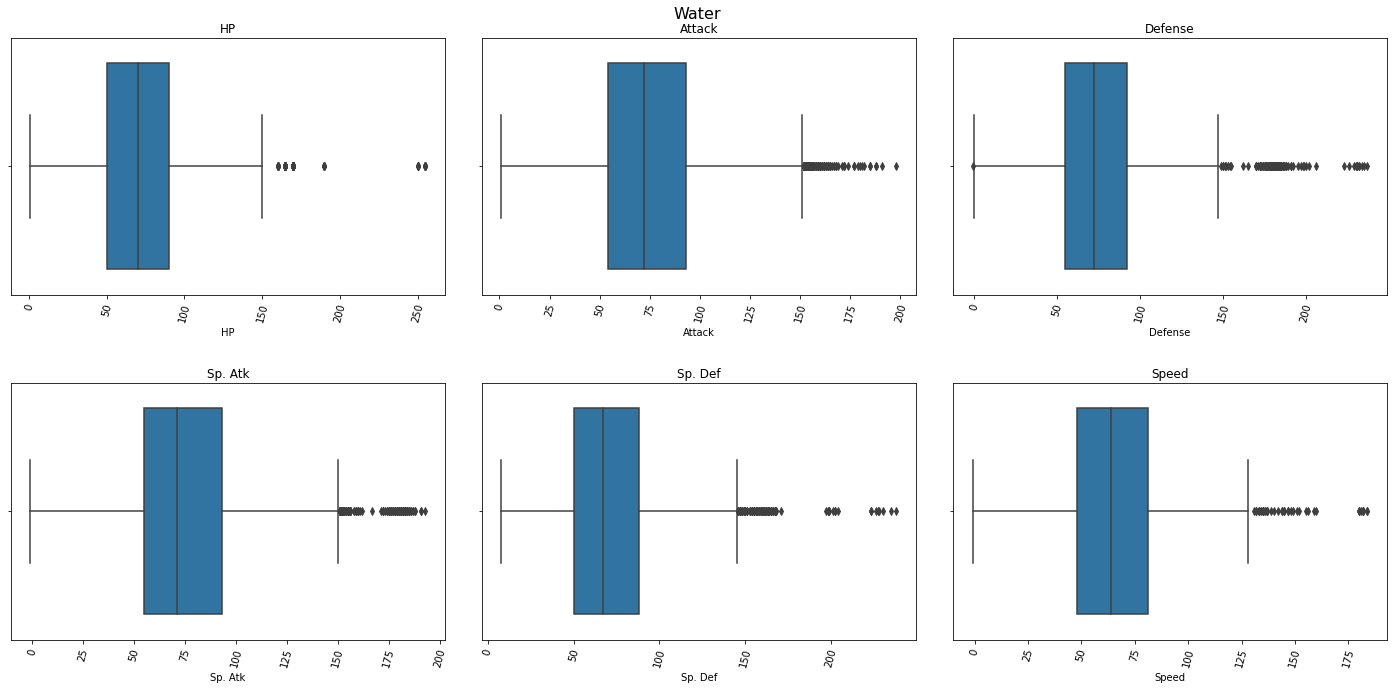

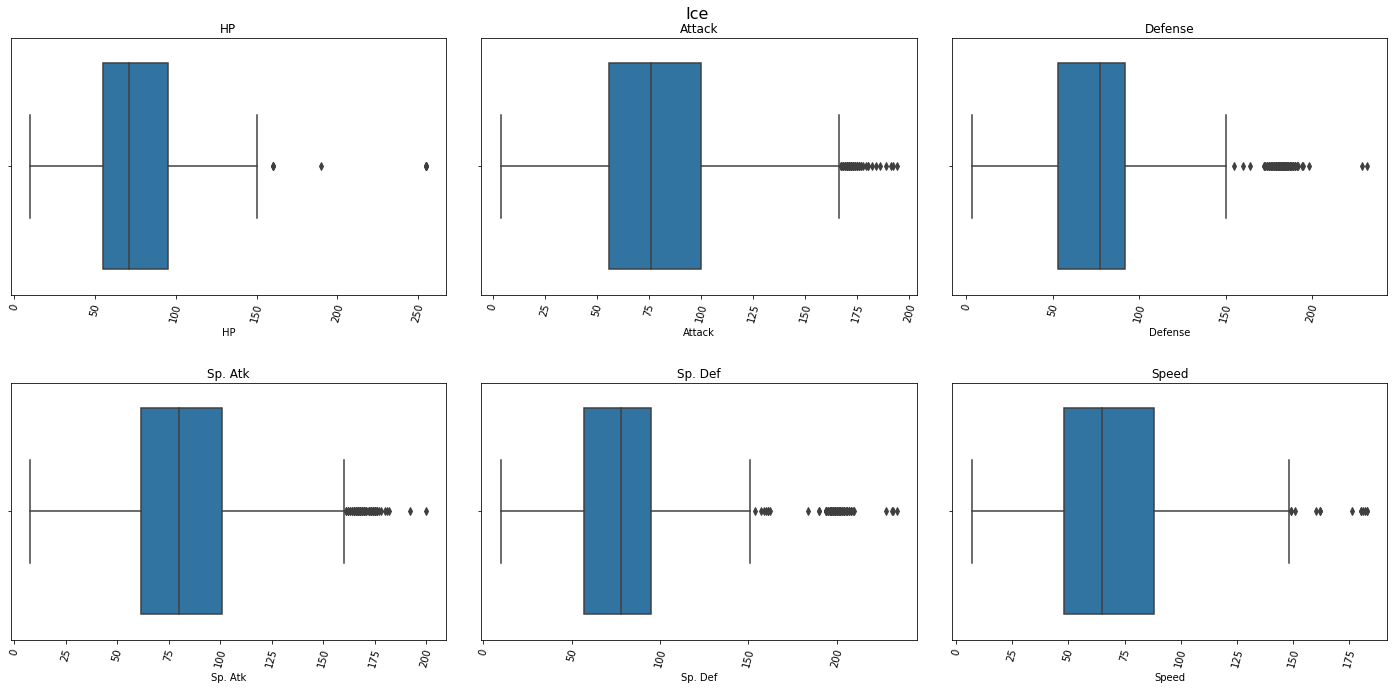

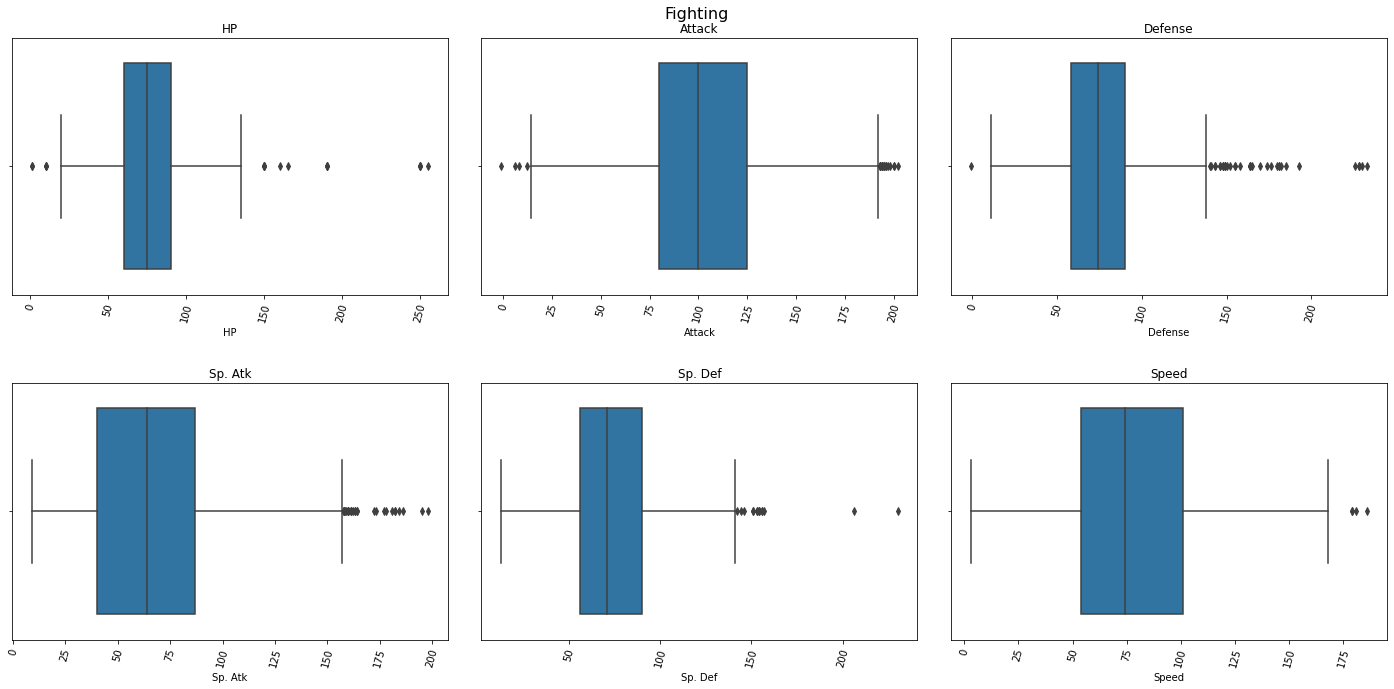

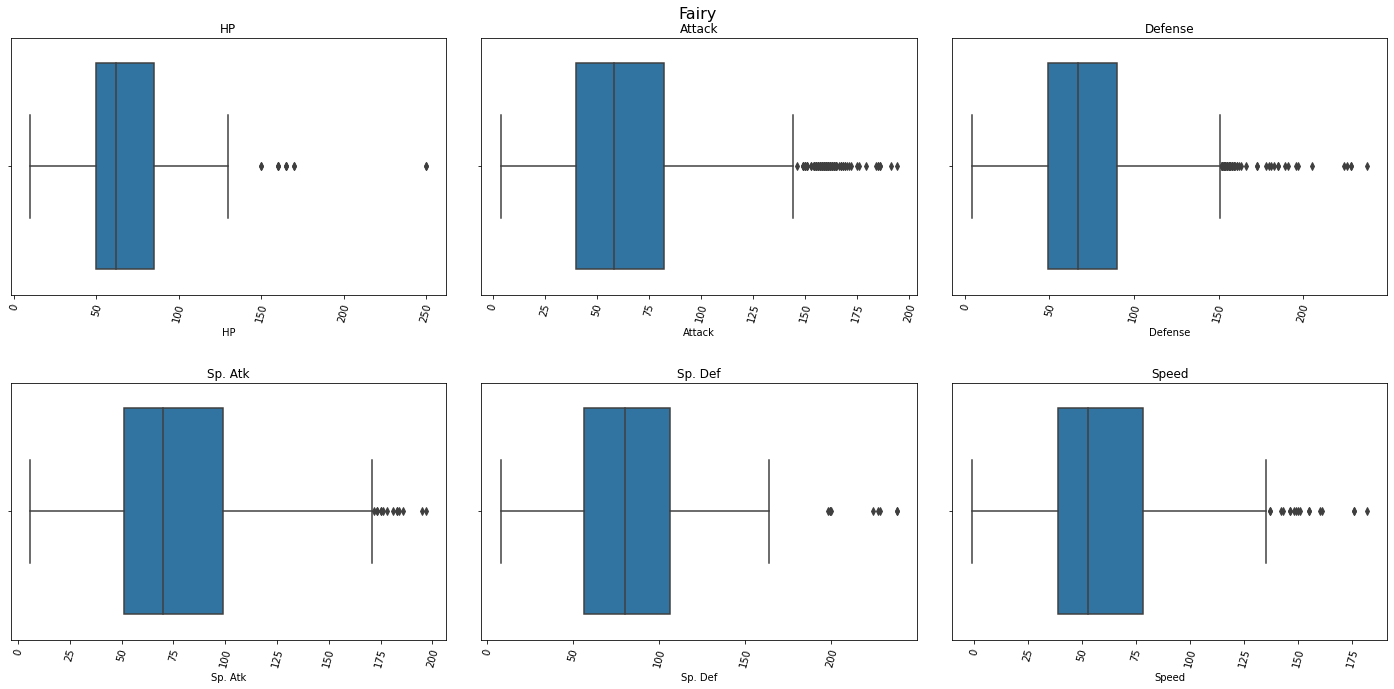

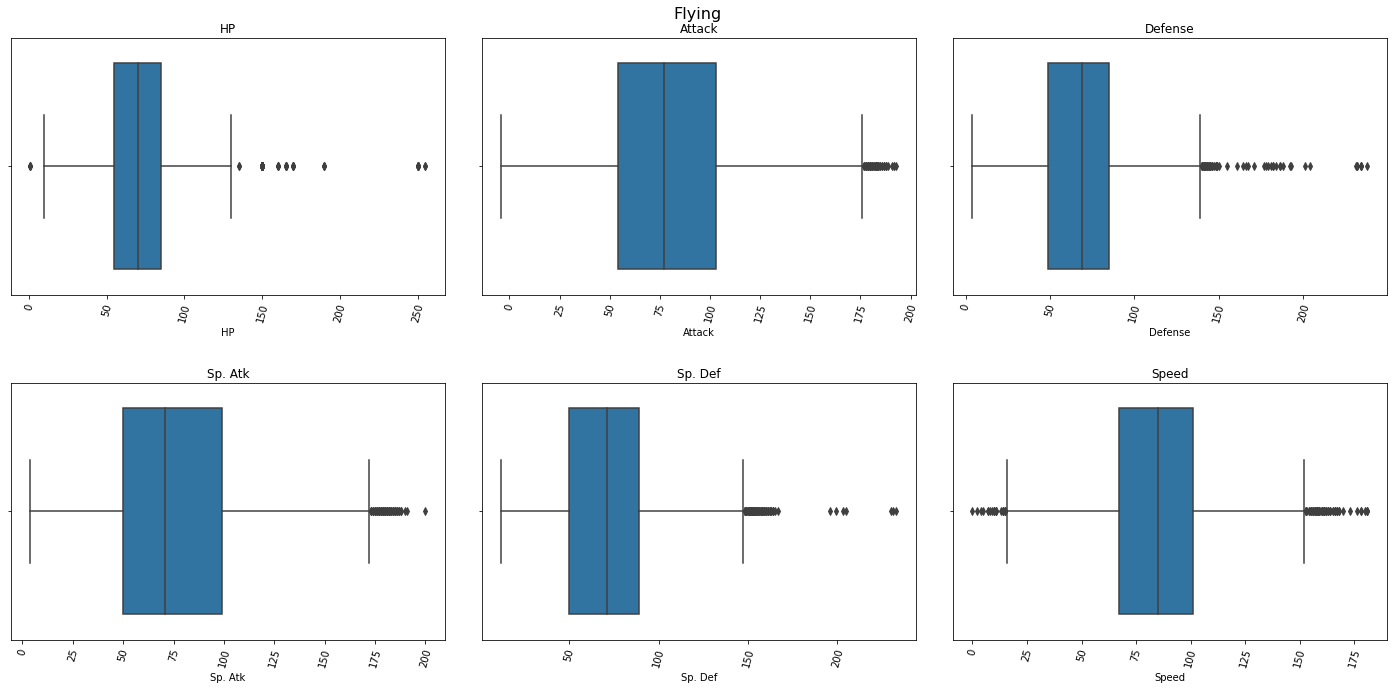

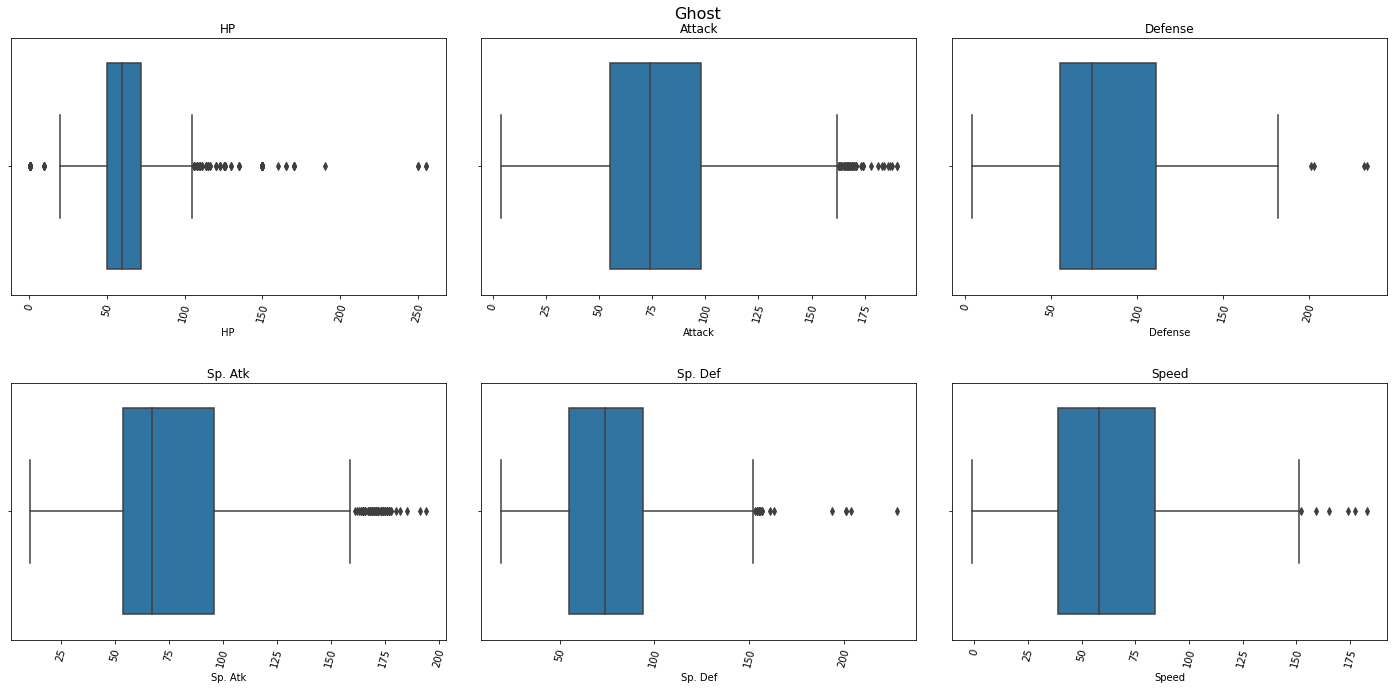

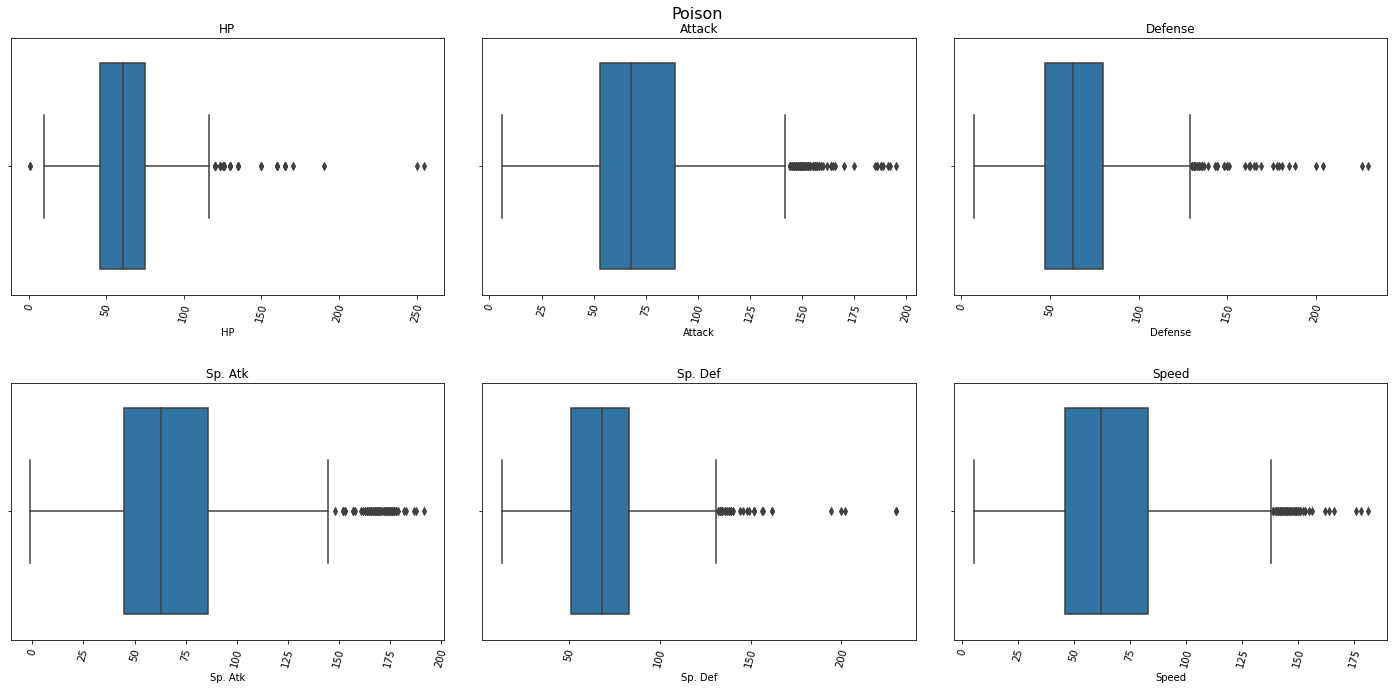

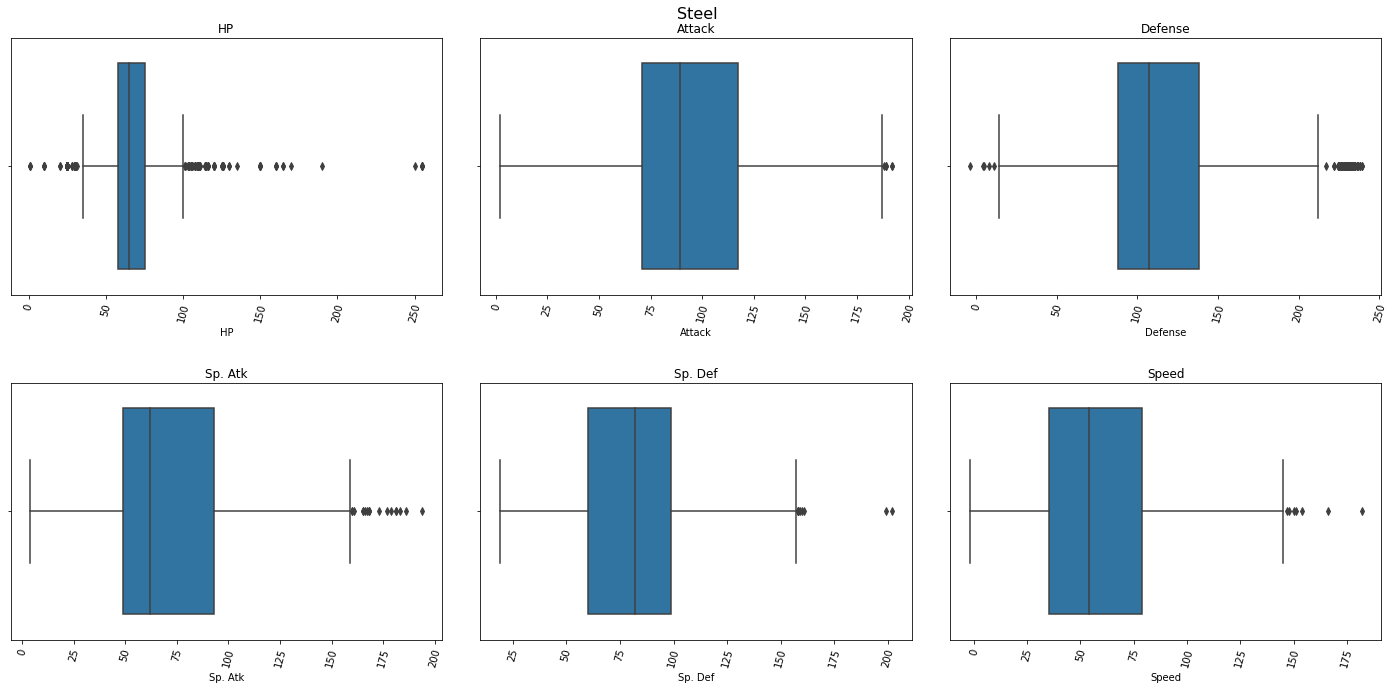

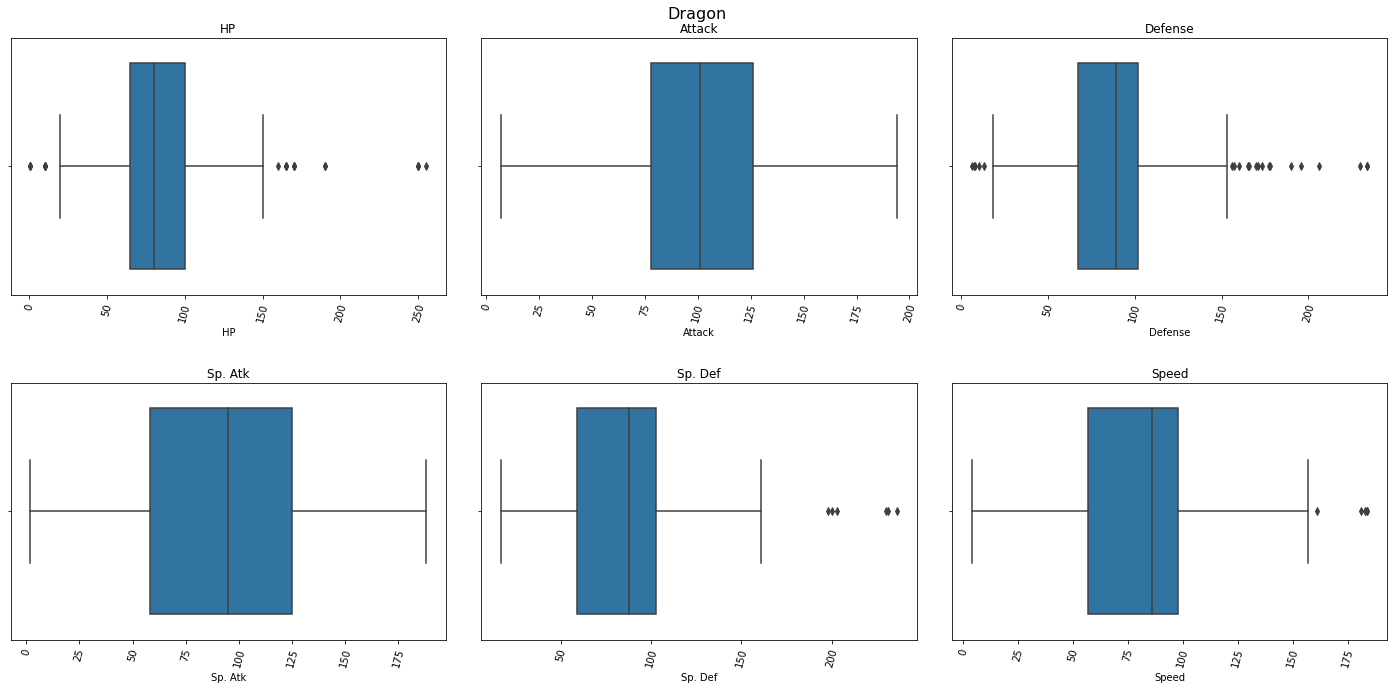

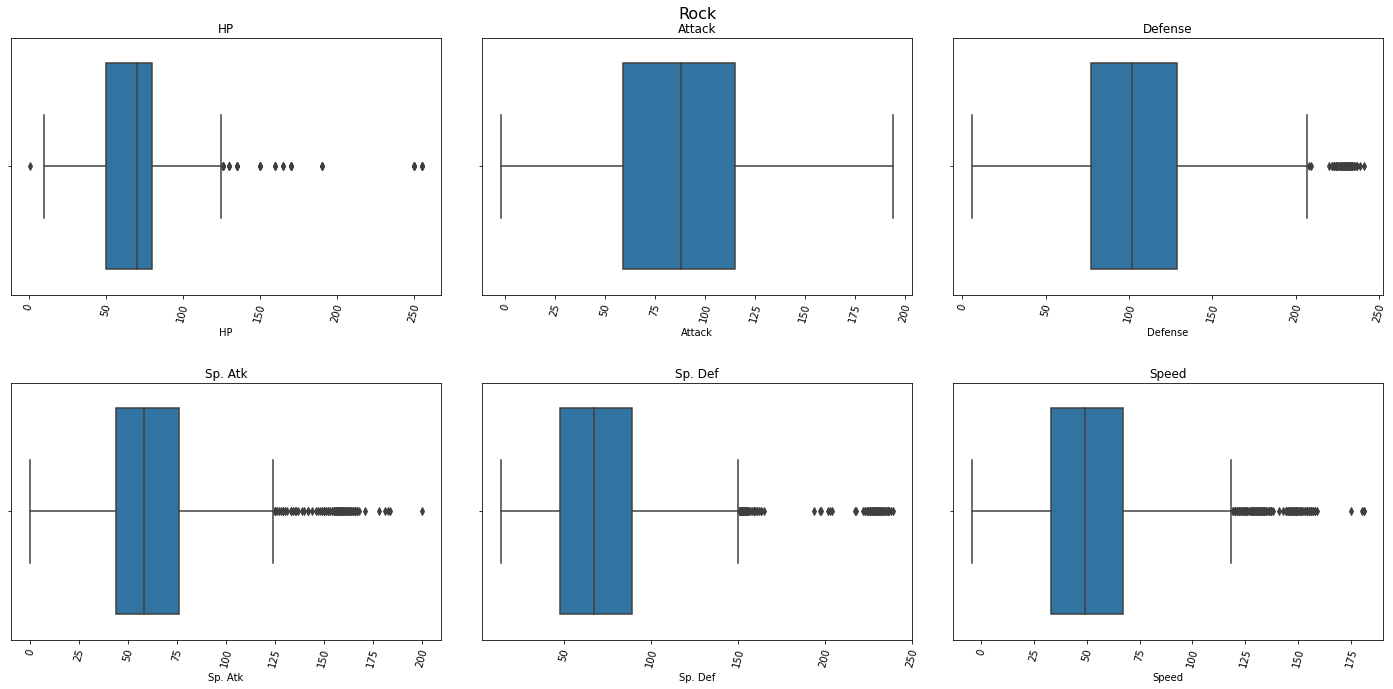

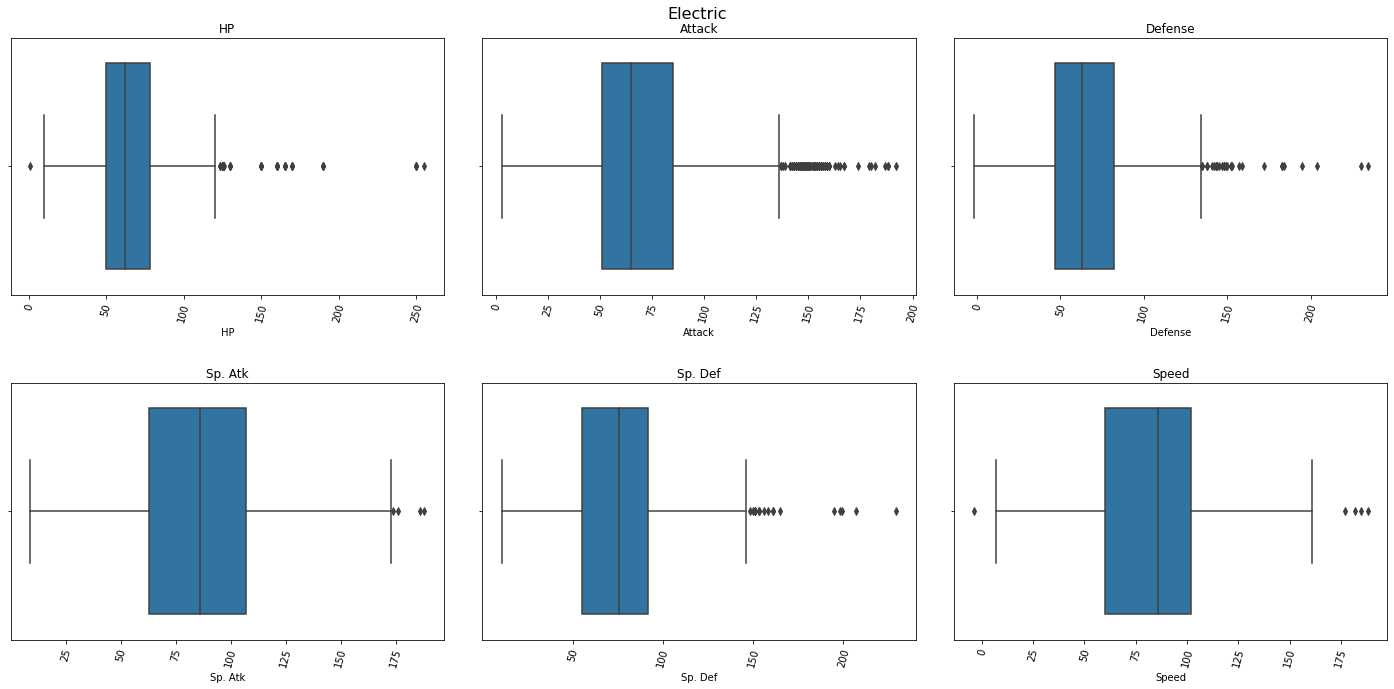

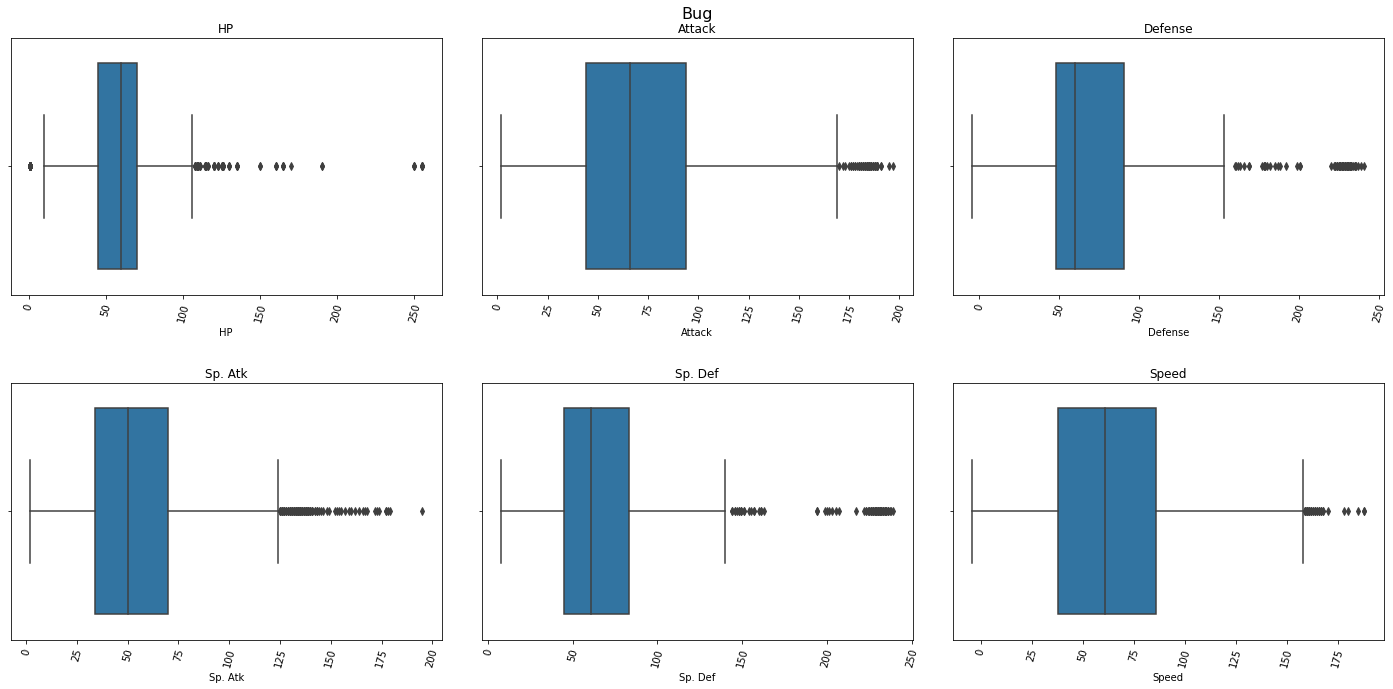

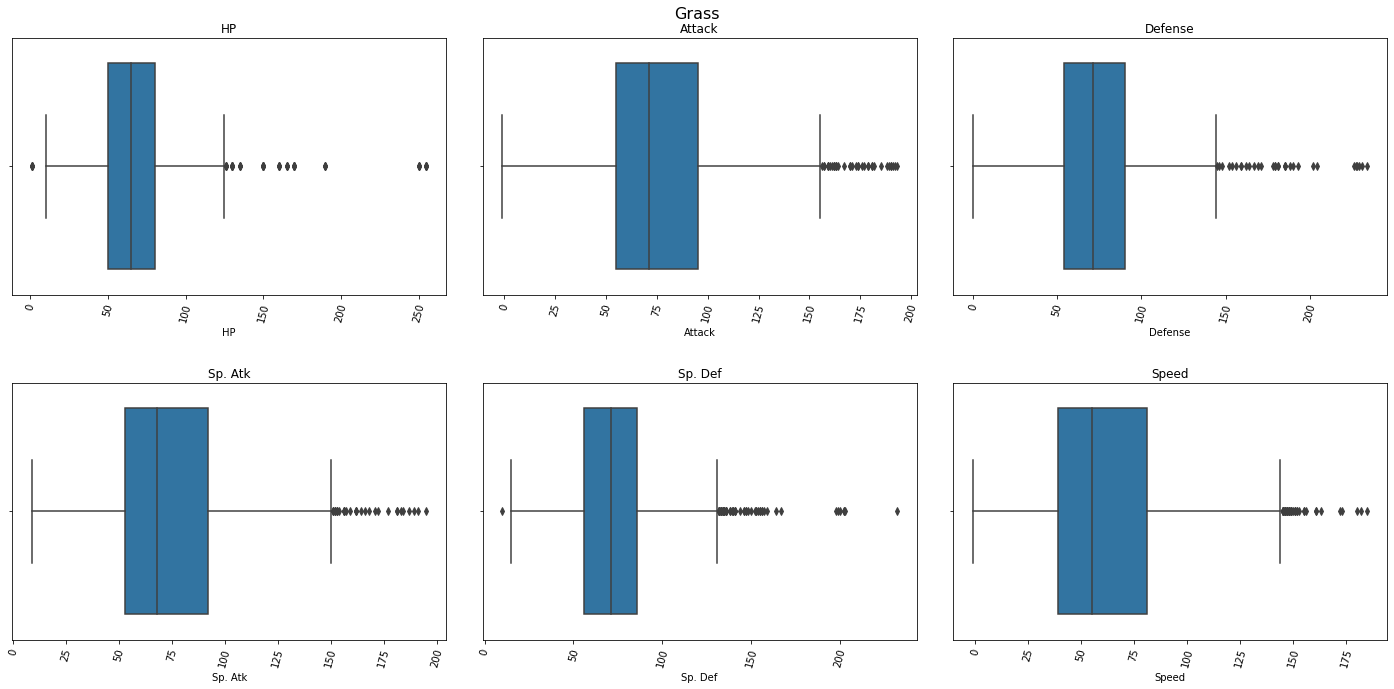

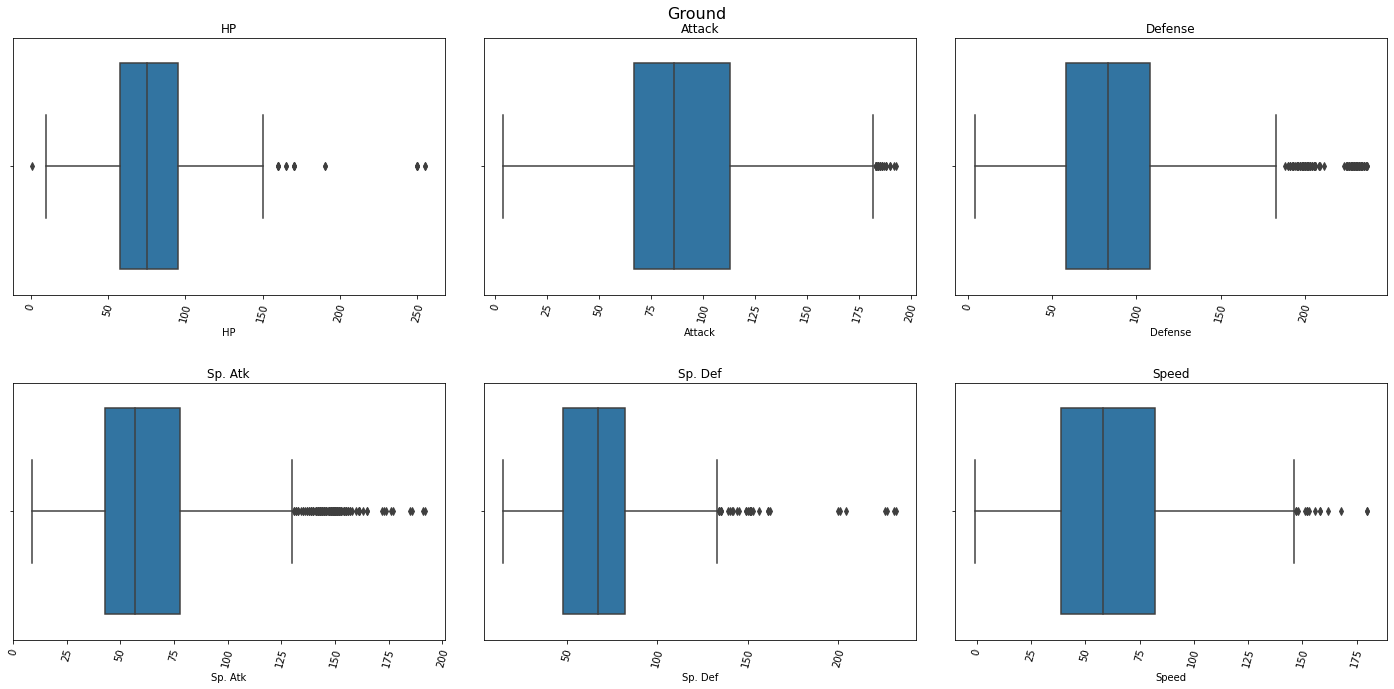

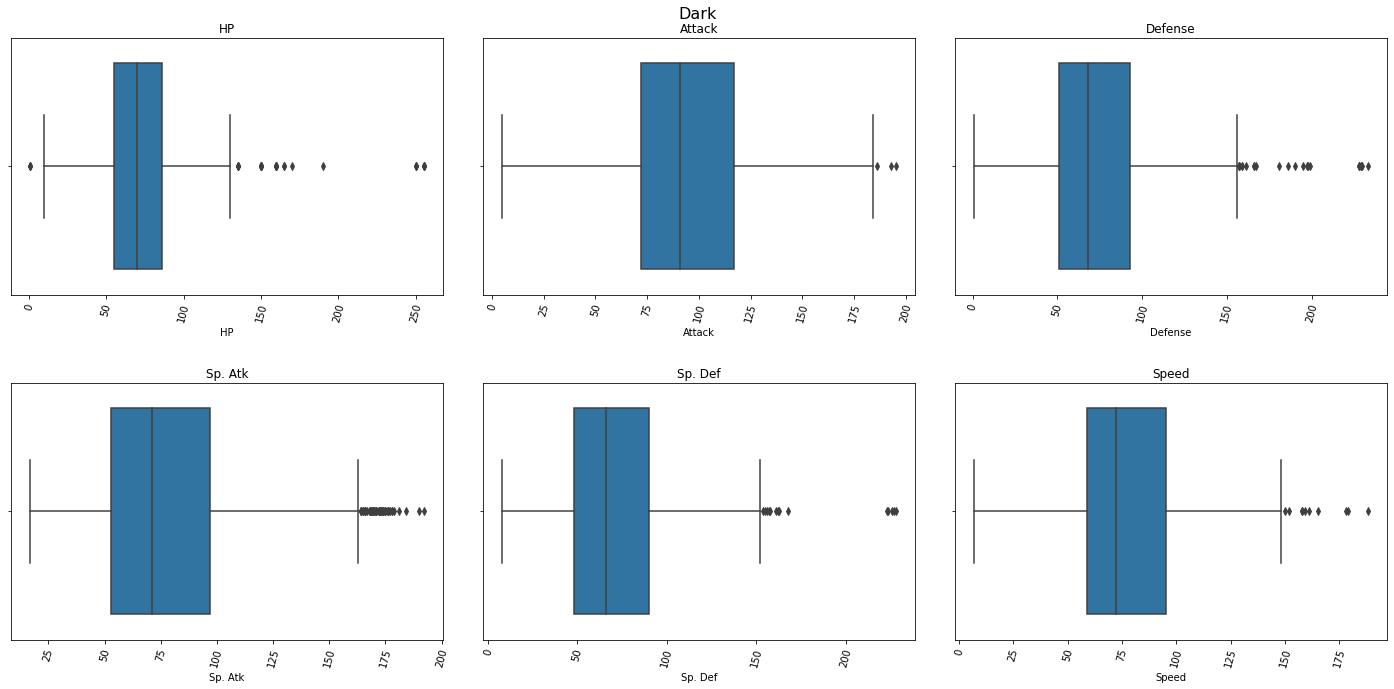

In [24]:
for ptype in get_type_list(data):
    plot_statistics_boxplots_by_type(ptype).suptitle(ptype, fontsize=16)


Some observations: 
- Seems that all the outlayers atempt to be in the right part of the plots. This could be becouse there are pokemons that contain two different types, and for example a pokemon like Scarmory, that is steal flying and has a good velocity, is outlyer in terms of steal pokemons.
- Also, legendary pokemons for sure apear as outlyers of every single type.
- Seems that all the pokemons present in the dataset contain more or less the same level, due that ther are not outliers in the bottom part of the graphics.
- Also, we can assume that the data does not contain that much noise in terms of fake numbers.

#### Number of legendaries

In [25]:
len(pokemons[pokemons['Legendary'] == True])

6639

I wanted to check how many legendayes are as thos are all outliers for sure

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

By now I will delete the columns that I think that are useless:
- Legenday tags, becouse I think that it cames implicit in the statistics
- Generation Tag, it doesnt care the generation of the pokemon. It does not give any valuable information.
- Name, The name is usless also when we want to figure out wich pokemon wins a combat
- Types, as we have seen in the visualitzation of data, the type is represented in the statistics.

In [26]:
pdata = data.copy()
def delete_first_cols(pdata):
    return pdata.drop(["Name", "Name__other", "Generation", "Generation__other", "Legendary", "Legendary__other"], axis = 1)
pdata = delete_first_cols(pdata)
pdata

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Wins
39087,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,True
30893,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,True
45278,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,True
16398,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,False
13653,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,Water,NaN,55.0,NaN,107.0,NaN,79.0,56.0,True
44732,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,Normal,NaN,65.0,59.0,70.0,79.0,79.0,33.0,False
38158,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,Normal,NaN,104.0,91.0,61.0,97.0,117.0,68.0,True
860,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,Electric,Dragon,50.0,70.0,101.0,112.0,97.0,83.0,True


I delete all the columns where the Type 1 and Type 1_other its null, as we are going to infeer the missing value from the median of each type statistics.

In [27]:
def delete_null_type_one(pdata):
    pdata = pdata.dropna(subset=['Type 1'] ,how='all')
    return pdata.dropna(subset=['Type 1__other'] ,how='all')
pdata = delete_null_type_one(pdata)
pdata

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Wins
39087,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,True
30893,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,True
45278,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,True
16398,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,False
13653,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,Water,NaN,55.0,NaN,107.0,NaN,79.0,56.0,True
44732,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,Normal,NaN,65.0,59.0,70.0,79.0,79.0,33.0,False
38158,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,Normal,NaN,104.0,91.0,61.0,97.0,117.0,68.0,True
860,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,Electric,Dragon,50.0,70.0,101.0,112.0,97.0,83.0,True


Split the dataset

In [28]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, test_index in split.split(pdata, pdata["Wins"]):
    train_index_compare = train_index
    strat_train_set = pdata.iloc[train_index]
    strat_test_set = pdata.iloc[test_index]

In [29]:
train_index_compare

array([ 5841,  8234, 17417, ...,  5372, 19441, 18127])

In [30]:
strat_train_set["Wins"].value_counts()/len(strat_train_set)

False    0.527646
True     0.472354
Name: Wins, dtype: float64

In [31]:
strat_test_set["Wins"].value_counts()/len(strat_test_set)

False    0.527621
True     0.472379
Name: Wins, dtype: float64

Here we infeer the statistics that are null using the median of each statistic of each type. If a pookemon has two types, the mean of the median of the statistic of that types is gonna be used, in orther to do a balance of statistics from both types.

In [32]:
def get_stat_by_type(stat, i, train_set, null_dataframe, dic_median_by_type):
    if null_dataframe.loc[i, "Type 2"]:
        train_set.loc[i, stat] = dic_median_by_type[stat][train_set.loc[i, "Type 1"]]
    else:    
        train_set.loc[i, stat] = (dic_median_by_type[stat][train_set.loc[i, "Type 1"]] + dic_median_by_type[stat][train_set.loc[i, "Type 2"]]) / 2

def get_stat_by_type_other(stat, i, train_set, null_dataframe, dic_median_by_type):
    stat_other = stat+"__other"
    if null_dataframe.loc[i, "Type 2__other"]:
        train_set.loc[i, stat_other] = dic_median_by_type[stat][train_set.loc[i, "Type 1__other"]]
    else:    
        train_set.loc[i, stat_other] = (dic_median_by_type[stat][train_set.loc[i, "Type 1__other"]] + dic_median_by_type[stat][train_set.loc[i, "Type 2__other"]]) / 2

def fill_na_statistics(stat, i, train_set, null_dataframe, dic_median_by_type):
    stat_other = stat+"__other"
    if null_dataframe.loc[i, stat]:
        get_stat_by_type(stat, i, train_set, null_dataframe, dic_median_by_type)
    if null_dataframe.loc[i, stat_other]:
        get_stat_by_type_other(stat, i, train_set, null_dataframe, dic_median_by_type)

def nan_treatment(train_set):
    null_dataframe = pandas.isna(train_set)
    columns_to_merge1 = ["Type 1", "Type 2", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
    columns_to_merge2 = ["Type 1__other", "Type 2__other", "HP__other", "Attack__other", "Defense__other", "Sp. Atk__other", "Sp. Def__other", "Speed__other"]
    pokemons = get_all_pokemons(train_set, columns_to_merge1, columns_to_merge2)
    pokemons_by_type = split_by_type(pokemons)
    dic_median_by_type , _ = structures_median_by_type(pokemons_by_type)
    for i,row in train_set.iterrows():
        fill_na_statistics("HP", i, train_set, null_dataframe, dic_median_by_type)
        fill_na_statistics("Attack", i, train_set, null_dataframe, dic_median_by_type)
        fill_na_statistics("Defense", i, train_set, null_dataframe, dic_median_by_type)
        fill_na_statistics("Sp. Atk", i, train_set, null_dataframe, dic_median_by_type)
        fill_na_statistics("Sp. Def", i, train_set, null_dataframe, dic_median_by_type)
        fill_na_statistics("Speed", i, train_set, null_dataframe, dic_median_by_type)
    return train_set

In [33]:
strat_train_set = nan_treatment(strat_train_set)
strat_train_set.info()

/home/quimpm/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22680 entries, 35284 to 43497
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type 1          22680 non-null  object 
 1   Type 2          11107 non-null  object 
 2   HP              22680 non-null  float64
 3   Attack          22680 non-null  float64
 4   Defense         22680 non-null  float64
 5   Sp. Atk         22680 non-null  float64
 6   Sp. Def         22680 non-null  float64
 7   Speed           22680 non-null  float64
 8   Type 1__other   22680 non-null  object 
 9   Type 2__other   11030 non-null  object 
 10  HP__other       22680 non-null  float64
 11  Attack__other   22680 non-null  float64
 12  Defense__other  22680 non-null  float64
 13  Sp. Atk__other  22680 non-null  float64
 14  Sp. Def__other  22680 non-null  float64
 15  Speed__other    22680 non-null  float64
 16  Wins            22680 non-null  bool   
dtypes: bool(1), float64(12), ob

We delete the types as we will not need them anymore

In [34]:
def drop_types(data_set):
    return  data_set.drop(["Type 1", "Type 2", "Type 1__other", "Type 2__other"], axis = 1)
strat_train_set = drop_types(strat_train_set)
strat_test_set = drop_types(strat_test_set)

In [35]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22680 entries, 35284 to 43497
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              22680 non-null  float64
 1   Attack          22680 non-null  float64
 2   Defense         22680 non-null  float64
 3   Sp. Atk         22680 non-null  float64
 4   Sp. Def         22680 non-null  float64
 5   Speed           22680 non-null  float64
 6   HP__other       22680 non-null  float64
 7   Attack__other   22680 non-null  float64
 8   Defense__other  22680 non-null  float64
 9   Sp. Atk__other  22680 non-null  float64
 10  Sp. Def__other  22680 non-null  float64
 11  Speed__other    22680 non-null  float64
 12  Wins            22680 non-null  bool   
dtypes: bool(1), float64(12)
memory usage: 2.8 MB


In [36]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9721 entries, 38361 to 41455
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              8748 non-null   float64
 1   Attack          8815 non-null   float64
 2   Defense         8735 non-null   float64
 3   Sp. Atk         8789 non-null   float64
 4   Sp. Def         8748 non-null   float64
 5   Speed           8758 non-null   float64
 6   HP__other       8710 non-null   float64
 7   Attack__other   8759 non-null   float64
 8   Defense__other  8724 non-null   float64
 9   Sp. Atk__other  8696 non-null   float64
 10  Sp. Def__other  8718 non-null   float64
 11  Speed__other    8760 non-null   float64
 12  Wins            9721 non-null   bool   
dtypes: bool(1), float64(12)
memory usage: 996.8 KB


In [37]:
strat_test_set_droped_nas = strat_test_set.dropna(how="any", axis=0)
strat_test_set_droped_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2732 entries, 38361 to 46115
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              2732 non-null   float64
 1   Attack          2732 non-null   float64
 2   Defense         2732 non-null   float64
 3   Sp. Atk         2732 non-null   float64
 4   Sp. Def         2732 non-null   float64
 5   Speed           2732 non-null   float64
 6   HP__other       2732 non-null   float64
 7   Attack__other   2732 non-null   float64
 8   Defense__other  2732 non-null   float64
 9   Sp. Atk__other  2732 non-null   float64
 10  Sp. Def__other  2732 non-null   float64
 11  Speed__other    2732 non-null   float64
 12  Wins            2732 non-null   bool   
dtypes: bool(1), float64(12)
memory usage: 280.1 KB


In [38]:
strat_test_set_droped_nas["Wins"].value_counts()/len(strat_test_set_droped_nas)

False    0.538799
True     0.461201
Name: Wins, dtype: float64

HUUUUUUUH NOT BAD PROPORTIONS, but the test set is still small :( Lets try with this anyway :)

With this done, we have our first preprocessing fase completed

## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [39]:
X_train = strat_train_set.drop(["Wins"], axis = 1)
y_train = strat_train_set["Wins"]
X_test = strat_test_set_droped_nas.drop(["Wins"], axis = 1)
y_test = strat_test_set_droped_nas["Wins"]

In [40]:
def print_metrics(y_test, y_test_pred, scores):
    print("Cross Validation: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print("Accuracy: "+str(accuracy_score(y_test, y_test_pred)))
    print("Recall: "+str(recall_score(y_test, y_test_pred)))
    print("Precision: "+str(precision_score(y_test, y_test_pred)))
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.show()

def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

Cross Validation: 0.85 accuracy with a standard deviation of 0.00
Accuracy: 0.8905563689604685
Recall: 0.8833333333333333
Precision: 0.8798418972332016


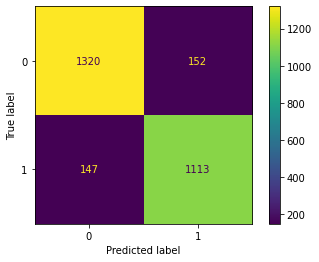

In [41]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=5)
y_test_pred = fit_and_predict(rf, X_train, y_train, X_test)
print_metrics(y_test, y_test_pred, scores)

This is the best model, we have an accuracy of 88-89 most of the cases. In terms of cross validation is the one with the bisggest score also. We can see in the confusion matrix that we allways have the same amountof false positives that false negatives.

Cross Validation: 0.77 accuracy with a standard deviation of 0.00
Accuracy: 0.8030746705710102
Recall: 0.7873015873015873
Precision: 0.786053882725832


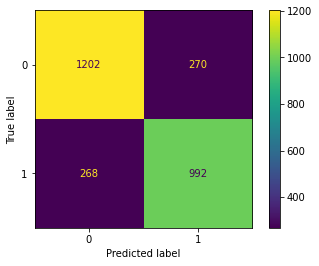

In [42]:
dtc = DecisionTreeClassifier()
scores = cross_val_score(dtc, X_train, y_train, cv=5)
y_test_pred = fit_and_predict(dtc, X_train, y_train, X_test)
print_metrics(y_test, y_test_pred, scores)

Cross Validation: 0.83 accuracy with a standard deviation of 0.00
Accuracy: 0.8795754026354319
Recall: 0.8817460317460317
Precision: 0.860573199070488


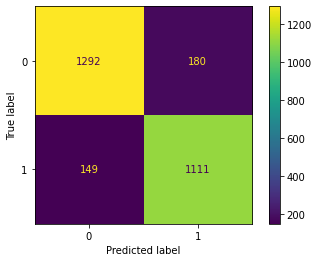

In [43]:
svc = SVC()
scores = cross_val_score(svc, X_train, y_train, cv=5)
y_test_pred = fit_and_predict(svc, X_train, y_train, X_test)
print_metrics(y_test, y_test_pred, scores)

Second best performing model.

Cross Validation: 0.77 accuracy with a standard deviation of 0.01
Accuracy: 0.794289897510981
Recall: 0.7849206349206349
Precision: 0.77265625


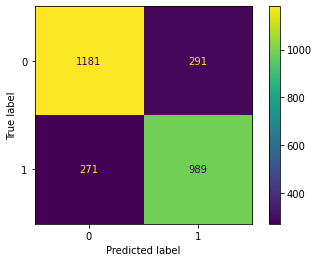

In [44]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X_train, y_train, cv=5)
y_test_pred = fit_and_predict(gnb, X_train, y_train, X_test)
print_metrics(y_test, y_test_pred, scores)

Cross Validation: 0.82 accuracy with a standard deviation of 0.00
Accuracy: 0.8605417276720352
Recall: 0.8547619047619047
Precision: 0.8447058823529412


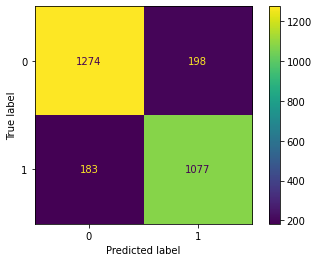

In [45]:
lr = LogisticRegression(random_state=1)
scores = cross_val_score(lr, X_train, y_train, cv=5)
y_test_pred = fit_and_predict(lr, X_train, y_train, X_test)
print_metrics(y_test, y_test_pred, scores)

3rd best performing model

### Some conclusions
As it was expected, the model did pretty nice without the type. Putting the type will have lead to do a one hot encoder making the number of features of the model increase a lot, geting the door open to possible overfiting of the model. And also, we can confirm that through the statistics we can, more or less, infeer the type of the pokemons in the visualitzation part, so i think that has been the right choice.

Also, we can see that after the split and remove of the null values in the test set, we remained with arround a 10% of the total of the total set. Wich is a pretty small test set having in mind the amount of data that we are using. So a possible better way of testing is increassing a little bit more the value of the partition of the tests in the StratifiedShufeledSplit (Increased teset test_set to 30% but still a little amout, eventho the accuraccy seems better than when working with 20%)

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [46]:
eclf = VotingClassifier( estimators=[('rf', rf), ('dtc', dtc), ('svc', svc), ('gnb', gnb), ('lr', lr)], voting='hard')
for clf, label in zip([rf, dtc, svc, gnb, lr, eclf], ['Random Forest', 'Decission Tree Classifier', 'Support Vector Classifier', 'Gaussian Naive Bayes', 'Logistic Regression', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.85 (+/- 0.00) [Random Forest]
Accuracy: 0.77 (+/- 0.01) [Decission Tree Classifier]
Accuracy: 0.83 (+/- 0.00) [Support Vector Classifier]
Accuracy: 0.77 (+/- 0.01) [Gaussian Naive Bayes]
Accuracy: 0.82 (+/- 0.00) [Logistic Regression]
Accuracy: 0.83 (+/- 0.00) [Ensemble]


Cross Validation: 0.83 accuracy with a standard deviation of 0.00
Accuracy: 0.8744509516837482
Recall: 0.873015873015873
Precision: 0.857365549493375


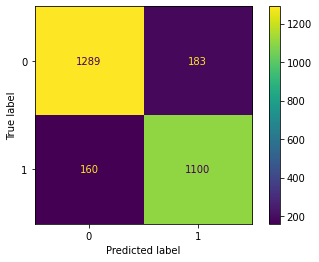

In [47]:
y_test_pred = fit_and_predict(eclf, X_train, y_train, X_test)
print_metrics(y_test, y_test_pred, scores)

I decided to use a simple ensambler. This one is a VotingClassifier ensambler in wich we put all of our models and each one does it's preddiction. This predictions are considered as a vote and the one with most of the botes is the winner.

As we can see the performance its a little bit worst than the RandomForest. It's pritty much obvious cuz all the models seem to fail in the same way, they have similar amounts of false negative than false possitives.

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

Cross Validation: 0.83 accuracy with a standard deviation of 0.00
Accuracy: 0.8930749910297812
Recall: 0.8944954128440367
Precision: 0.8796992481203008


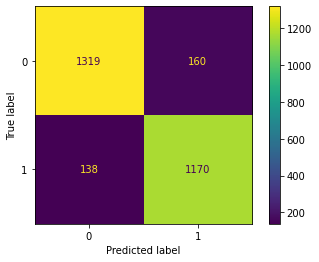

['model.joblib']

In [59]:
__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"
data = pandas.read_csv(datasets_path / "data.train", index_col=0)
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, test_index in split.split(data, data["Wins"]):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]
strat_train_set = delete_null_type_one(strat_train_set)
X_train = strat_train_set.drop(["Wins"], axis = 1)
y_train = strat_train_set["Wins"]
strat_test_indexes = drop_types(delete_null_type_one(delete_first_cols(strat_test_set))).dropna(how="any", axis=0).index
strat_test_set = strat_test_set.loc[strat_test_indexes]
X_test = strat_test_set.drop(["Wins"], axis = 1)
y_test = strat_test_set["Wins"]

def transformer_function(X_train):
    return drop_types(nan_treatment(delete_first_cols(X_train)))

predictor = Pipeline(
    [
        ("preprocessing", FunctionTransformer(transformer_function)),
        ("predictor", RandomForestClassifier()),
    ]
)



y_train_predict = fit_and_predict(predictor, X_train, y_train, X_test)
print_metrics(y_test, y_train_predict, scores)
dump(predictor, 'model.joblib')

Here as I delete some rows, I had problems between the matching of the sizes between X_test and y_test, so I decided to delete the rows beforehand.

Also, as we apply the pipeline to X_train and there we delete some columns. We have to delete this same columns to the test set. And last but not least, test set can not have any nulls on their values, so we delete the nulls also.

For doing this, I decided to use a FunctionTransformer, as all the transformations where done using custom functions deffined along all the notebook.

To make it easyer for the tournament, I will dump this model and dedlivered to you so that u can charge it into ur noterbook and used directly. :)